In [2]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
wireplane = "Z"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
    #    for k in range(nticks):
    #        waveforms.append(data[string+str(k)].astype(np.int16))
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    # filtered_peak = extract_peak_info(cln_filtered_data)[1]  # before
    filtered_peak = extract_peak_info(filtered_data)[1]  # new
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

In [9]:
#Load Training Data
#path = "../../dunesnb/1dcnn/train/train/nu_cc/"
#path2 = "../../dunesnb/1dcnn/train/train/nu_es/"

# NEW DATA SET WITH
path = "../../Workspace/new_data/train_v1/nu_cc/"
path2 = "../../Workspace/new_data/train_v1/nu_cc/"

test1_sig = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
test1_clean = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]

test2_sig = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
test2_clean = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]


In [10]:
print(len(test1_sig), len(test1_clean))

55 55


In [11]:
print(len(test2_sig), len(test2_clean))

55 55


In [12]:
test1_sig

['../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en0-Z-signal-62286406-0-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en0-Z-signal-62286406-1-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en0-Z-signal-62286406-2-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en0-Z-signal-62286406-3-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en0-Z-signal-62286406-4-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en0-Z-signal-62302644-0-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en0-Z-signal-62302644-1-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en1-Z-signal-62286407-0-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en1-Z-signal-62286407-1-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en1-Z-signal-62286407-2-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en1-Z-signal-62286407-3-0.npy',
 '../../Workspace/new_data/train_v1/nu_cc/snb-nucc-en1-Z-signal-62286407-4-0.npy',
 '..

In [13]:
combined_test1_sig = np.concatenate([np.load(fname) for fname in test1_sig])
combined_test1_clean = np.concatenate([np.load(fname) for fname in test1_clean])

combined_test2_sig = np.concatenate([np.load(fname) for fname in test2_sig])
combined_test2_clean = np.concatenate([np.load(fname) for fname in test2_clean])

In [14]:
wave_nu_cc_sig = get_std_waveforms(combined_test1_sig)
wave_nu_cc_clean = get_std_waveforms(combined_test1_clean)

wave_nu_es_sig = get_std_waveforms(combined_test2_sig)
wave_nu_es_clean = get_std_waveforms(combined_test2_clean)

In [15]:
print(wave_nu_cc_sig.shape, wave_nu_cc_clean.shape)
print(wave_nu_es_sig.shape, wave_nu_es_clean.shape)

(114709, 200) (114709, 200)
(114709, 200) (114709, 200)


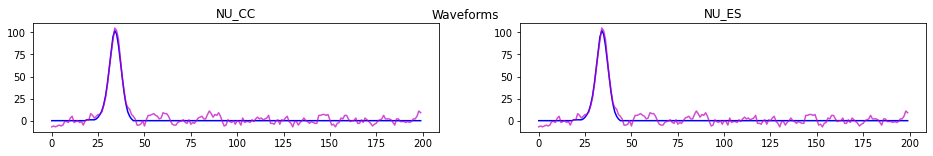

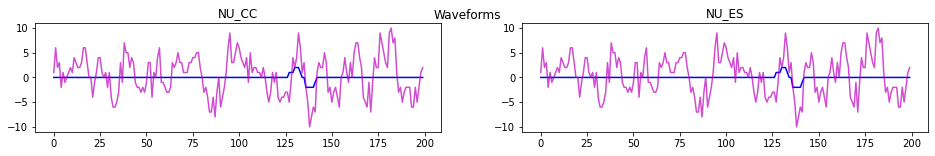

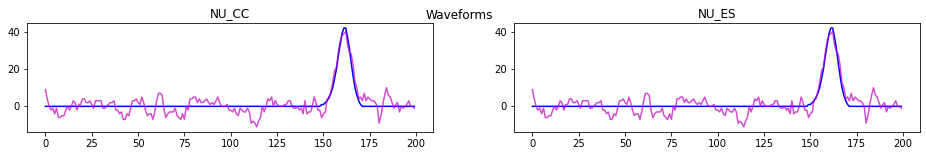

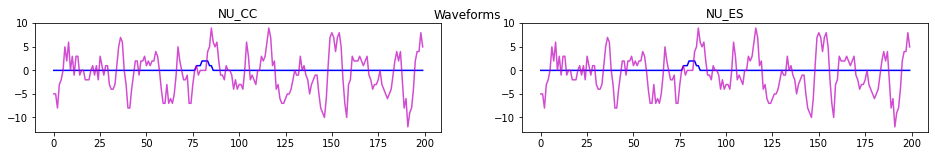

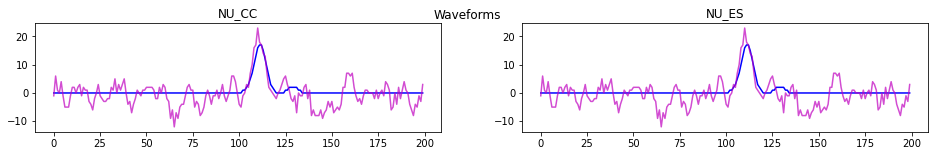

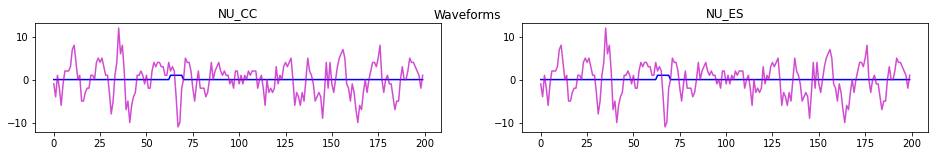

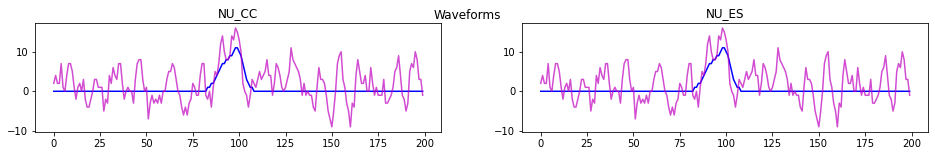

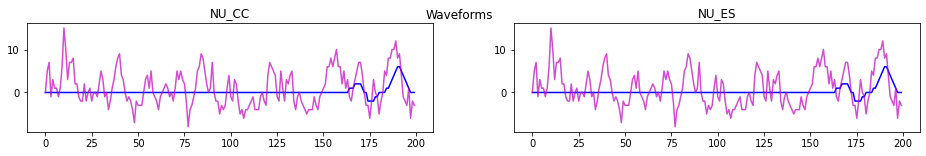

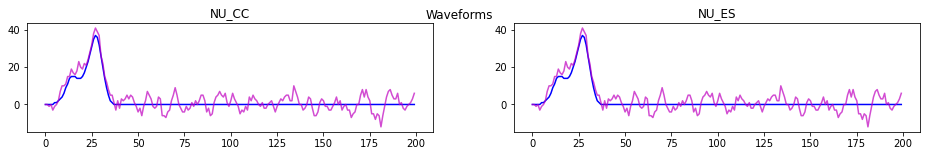

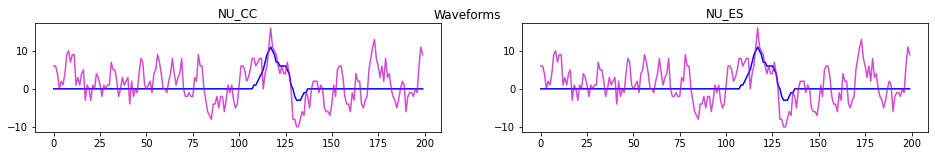

In [16]:
num = 0
for idx in range(num,num+10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
    fig.suptitle('Waveforms')
    ax1.plot(wave_nu_cc_clean[idx],color='blue', label='clean')
    ax1.plot(wave_nu_cc_sig[idx],color='m',alpha=0.7, label='data')
    ax1.set_title("NU_CC")

    ax2.plot(wave_nu_es_clean[idx],color='blue', label='clean')
    ax2.plot(wave_nu_es_sig[idx],color='m',alpha=0.7, label='data')
    ax2.set_title("NU_ES")
    plt.show()